In [2]:
#A program that takes a look at stock market over the last 10 years and predicts future rates as well as predicts how much you'd have earned if you had bought the S&P now in any part of the last 10 years

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_pal= sns.color_palette()

In [32]:
stock_prices= pd.read_csv('C:\\Users\\sonam\\Downloads\\HistoricalData_1726504985107.csv', index_col= 'Date', parse_dates= True, na_values= '0')
#na_values ensures that the unwanted zeros in the data be null values so we can fix it easily.
stock_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2527 entries, 2024-09-13 to 2014-09-16
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Close/Last  2527 non-null   float64
 1   Open        2516 non-null   float64
 2   High        2516 non-null   float64
 3   Low         2516 non-null   float64
dtypes: float64(4)
memory usage: 98.7 KB


Data Separation:

In [33]:
#Creating separate dataset for each column
closing = stock_prices[['Close/Last']]
date= stock_prices.index
high = stock_prices[['High']]
low = stock_prices[['Low']]

<Axes: xlabel='Date'>

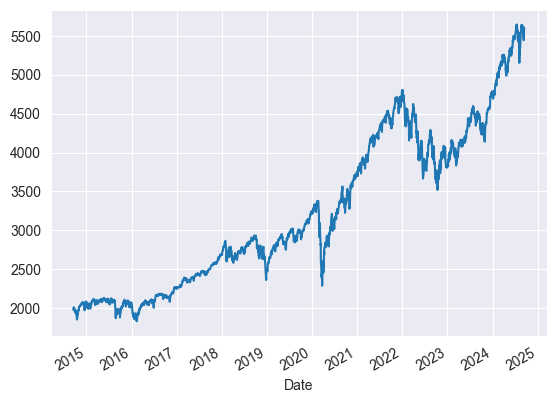

In [34]:
stock_prices['Open']= stock_prices['Open'].ffill() #filling out the values that were zeros
need_closing = stock_prices['Open'].sort_index().loc['12/31/2014':'12/31/2016']
stock_prices['Open'].plot()

<Axes: title={'center': 'S&P 500 Stock Price over 10-Year Period'}, xlabel='Date'>

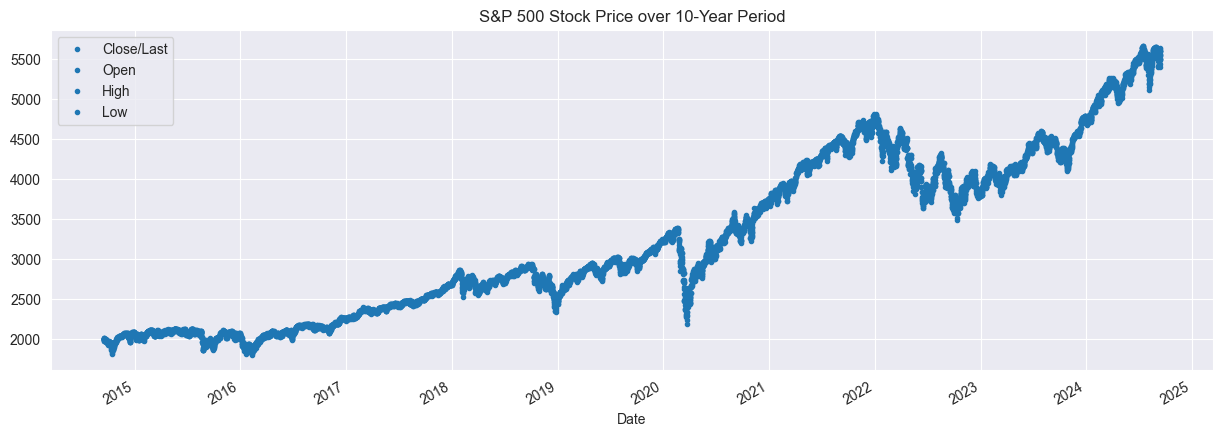

In [6]:
stock_prices.plot(style= '.', figsize= (15,5), color= color_pal[0], title= 'S&P 500 Stock Price over 10-Year Period')

Train/Test Split

C:\Users\sonam\AppData\Local\Temp\ipykernel_27256\3276125909.py:6: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  ax.legend('Train Data', 'Test Data')


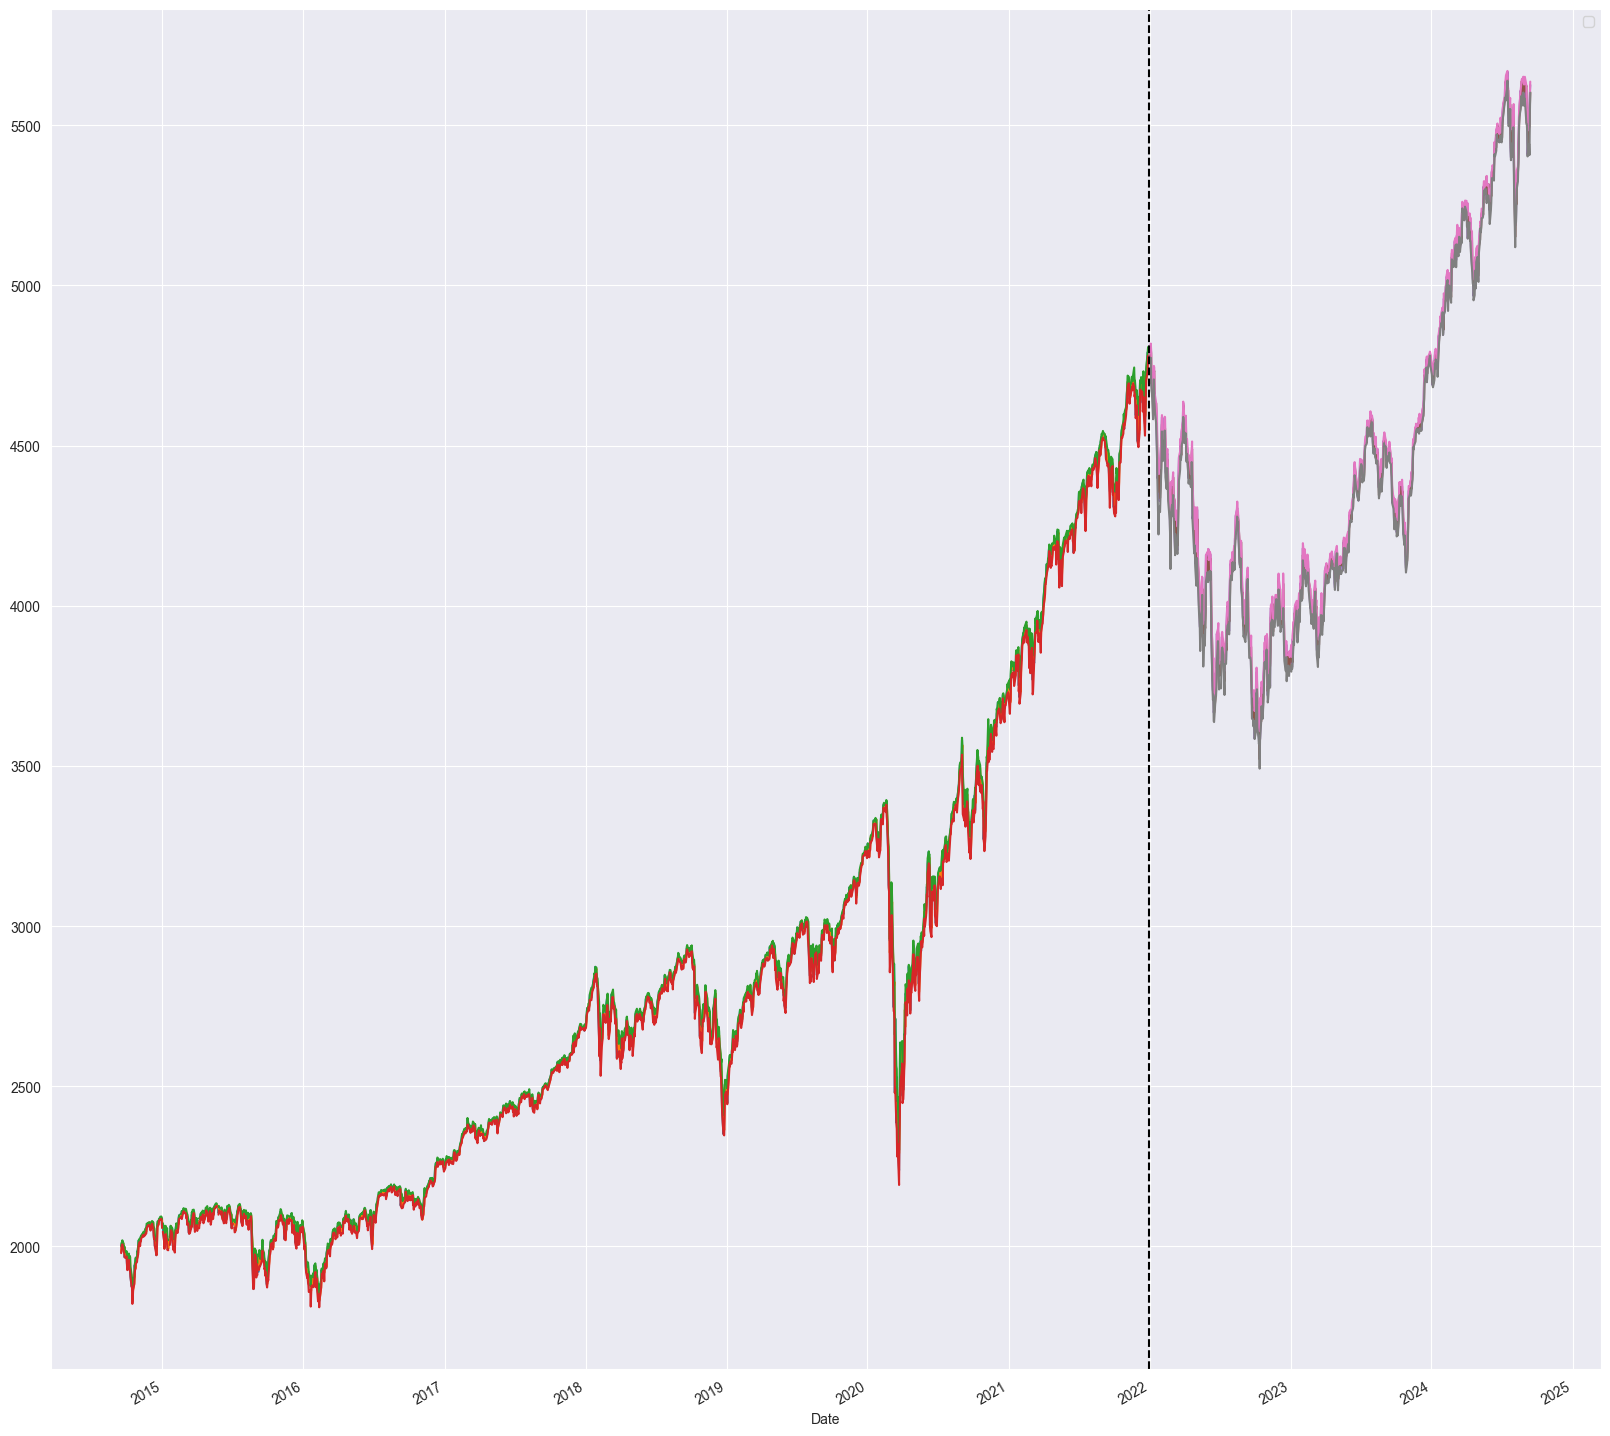

In [7]:
train= stock_prices.iloc[stock_prices.index < '2021-12-31']
test= stock_prices.iloc[stock_prices.index >= '2021-12-31']
fig, ax= plt.subplots(figsize= (20,20))
train.plot(ax=ax, label='Train Data')
test.plot(ax=ax, label='Test Data')
ax.legend('Train Data', 'Test Data')
ax.axvline('2021-12-31', color='black', linestyle='--')

In [18]:
def create_features(stock_prices):
    stock_prices = stock_prices.copy()
    stock_prices['day'] = stock_prices.index.day
    stock_prices['dayofweek'] = stock_prices.index.dayofweek
    stock_prices['quarter'] = stock_prices.index.quarter
    stock_prices['month'] = stock_prices.index.month
    
    # Adding lag features
    stock_prices['lag_1'] = stock_prices['Close/Last'].shift(1)
    stock_prices['lag_5'] = stock_prices['Close/Last'].shift(5)
    stock_prices['rolling_mean_5'] = stock_prices['Close/Last'].rolling(window=5).mean()
    stock_prices['rolling_std_5'] = stock_prices['Close/Last'].rolling(window=5).std()
    
    stock_prices = stock_prices.dropna()  # Remove any rows with NaN values
    return stock_prices



<Axes: xlabel='month', ylabel='Close/Last'>

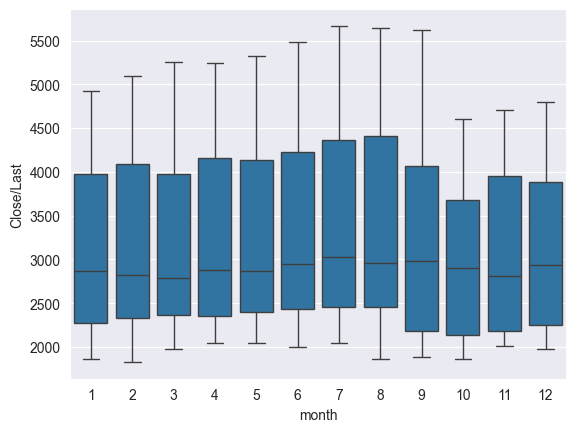

In [19]:
# fig, ax= plt.subplots(figsize= (20,20))
sns.boxplot(data= stock_prices, x= 'month', y= 'Close/Last')


In [20]:
train = create_features(train)
test = create_features(test)

FEATURES = ['day', 'month', 'dayofweek', 'quarter', 'lag_1', 'lag_5', 'rolling_mean_5', 'rolling_std_5']
TARGET= ['Close/Last']

In [21]:
x_train= train[FEATURES]
y_train= train[TARGET]
x_test= test[FEATURES]
y_test= test[TARGET]

In [22]:
reg = xgb.XGBRegressor(n_estimators=500, learning_rate=0.01, max_depth=6, subsample=0.8, colsample_bytree=0.8, early_stopping_rounds=50)
reg.fit(x_train, y_train,
        eval_set= [(x_train, y_train), (x_test, y_test)],verbose= 100)


[0]	validation_0-rmse:721.84389	validation_1-rmse:1741.31304
[100]	validation_0-rmse:270.18190	validation_1-rmse:833.47467
[200]	validation_0-rmse:103.43095	validation_1-rmse:514.93737
[300]	validation_0-rmse:43.61302	validation_1-rmse:406.41154
[400]	validation_0-rmse:24.19179	validation_1-rmse:371.43332
[499]	validation_0-rmse:18.26691	validation_1-rmse:360.06506


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [23]:
fi= pd.DataFrame(data= reg.feature_importances_, index=reg.feature_names_in_, columns=['Importance'])

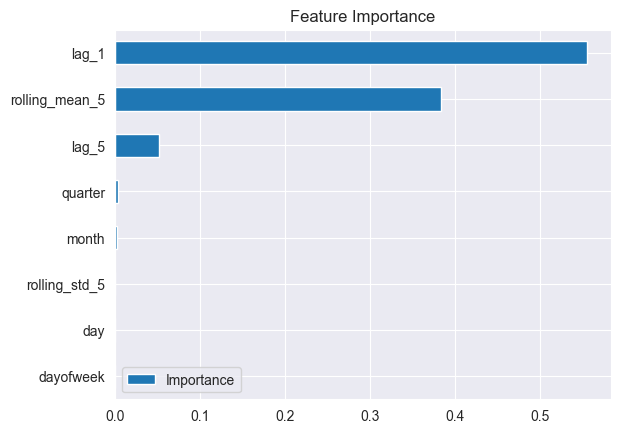

In [24]:
fi.sort_values('Importance').plot(kind='barh', title= 'Feature Importance')
plt.show()

Forecast on Test

KeyError: 'prediction'

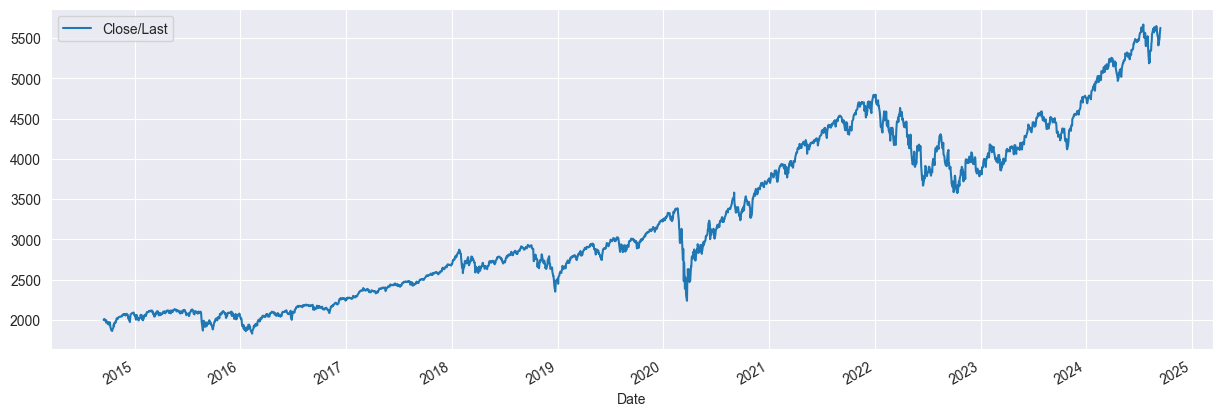

In [25]:
test['prediction']= reg.predict(x_test)
stock_prices= stock_prices.merge(test[['prediction']], how= 'left', left_index= True, right_index= True)
ax= stock_prices[['Close/Last']].plot(figsize=(15,5))
stock_prices['prediction'].plot(ax=ax, style= '.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

Close/Last     Open     High      Low  day  dayofweek  quarter  \
Date                                                                         
2024-09-13     5626.02  5603.34  5636.27  5601.65   13          4        3   
2024-09-12     5595.76  5557.48  5600.71  5535.50   12          3        3   
2024-09-11     5554.13  5496.42  5560.41  5406.96   11          2        3   
2024-09-10     5495.52  5490.51  5497.91  5441.72   10          1        3   
2024-09-09     5471.05  5442.07  5484.20  5434.49    9          0        3   
...                ...      ...      ...      ...  ...        ...      ...   
2014-09-22     1994.29  2009.08  2009.08  1991.01   22          0        3   
2014-09-19     2010.40  2012.74  2019.26  2006.59   19          4        3   
2014-09-18     2011.36  2003.07  2012.34  2003.07   18          3        3   
2014-09-17     2001.57  1999.30  2010.74  1993.29   17          2        3   
2014-09-16     1998.98  1981.93  2002.28  1979.06   16          1        3   

            month   prediction  
Date                            
2024-09-13      9  2784.113281  
2024-09-12      9  2784.113281  
2024-09-11      9  2784.113281  
2024-09-10      9  2784.113281  
2024-09-09      9  2784.113281  
...           ...          ...  
2014-09-22      9          NaN  
2014-09-19      9          NaN  
2014-09-18      9          NaN  
2014-09-17      9          NaN  
2014-09-16      9          NaN  

[2527 rows x 9 columns]